# Entraînement d'un réseau de neurones pour jouer au Go

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/auduvignac/deep_learning_go/blob/main/src/train_go_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## Description

- [https://www.lamsade.dauphine.fr/~cazenave/DeepLearningProject.html](https://www.lamsade.dauphine.fr/~cazenave/DeepLearningProject.html)  
- L'objectif est d'entraîner un réseau pour jouer au jeu de Go.  
- Afin de garantir une équité en termes de ressources d'entraînement, le nombre de paramètres des réseaux soumis doit être inférieur à 100 000.  
- Le nombre maximal d'étudiants par équipe est de deux.  
- Les données utilisées pour l'entraînement proviennent des parties auto-jouées du programme Katago Go.  
- Le jeu de données d'entraînement contient un total de 1 000 000 de parties différentes.  
- Les données d'entrée sont composées de 31 plans de taille 19x19 :  
  - Couleur au trait  
  - Échelles  
  - État actuel sur deux plans  
  - Deux états précédents sur plusieurs plans  
- Les cibles de sortie sont :  
  - **La politique** : un vecteur de taille 361 avec `1.0` pour le coup joué, `0.0` pour les autres coups.  
  - **La valeur** : une valeur entre `0.0` et `1.0` fournie par la recherche d'arbre Monte-Carlo, représentant la probabilité de victoire de Blanc.

- Le projet a été écrit et fonctionne sous Ubuntu 22.04.  
- Il utilise TensorFlow 2.9 et Keras pour le réseau.  
- Un exemple de réseau convolutionnel avec deux têtes est donné dans le fichier `golois.py` et est sauvegardé dans le fichier `test.h5`.  
- Les réseaux que vous concevez et entraînez doivent également avoir les mêmes têtes de politique et de valeur et être sauvegardés au format `.h5`.  
- Un exemple de réseau et un épisode d'entraînement sont fournis dans le fichier `golois.py`.  
- Si vous souhaitez compiler la bibliothèque Golois, vous devez installer **Pybind11** et exécuter `compile.sh`.

## Tournois

- Toutes les deux semaines environ, j'organiserai un tournoi entre les réseaux que vous téléchargez.  
- Chaque nom de réseau correspond aux noms des étudiants qui ont conçu et entraîné le réseau.  
- Le modèle doit être sauvegardé au format **Keras h5**.  
- Un tournoi en **round robin** sera organisé et les résultats seront envoyés par e-mail.  
- Chaque réseau sera utilisé par un moteur **PUCT**, qui disposera de **2 secondes de temps CPU** par coup pour jouer dans le tournoi.

## Exemple de réseau

```python
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import gc
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import golois

planes = 31
moves = 361
N = 10000
epochs = 20
batch = 128
filters = 32

input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype("float32")

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical(policy)

value = np.random.randint(2, size=(N,))
value = value.astype("float32")

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype("float32")

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype("float32")

print("Tensorflow version", tf.__version__)
print("getValidation", flush=True)
golois.getValidation(input_data, policy, value, end)


input = keras.Input(shape=(19, 19, planes), name="board")
x = layers.Conv2D(filters, 1, activation="relu", padding="same")(input)
for i in range(5):
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
policy_head = layers.Conv2D(
    1,
    1,
    activation="relu",
    padding="same",
    use_bias=False,
    kernel_regularizer=regularizers.l2(0.0001),
)(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation("softmax", name="policy")(policy_head)
value_head = layers.Conv2D(
    1,
    1,
    activation="relu",
    padding="same",
    use_bias=False,
    kernel_regularizer=regularizers.l2(0.0001),
)(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(
    50, activation="relu", kernel_regularizer=regularizers.l2(0.0001)
)(value_head)
value_head = layers.Dense(
    1,
    activation="sigmoid",
    name="value",
    kernel_regularizer=regularizers.l2(0.0001),
)(value_head)

model = keras.Model(inputs=input, outputs=[policy_head, value_head])

model.summary()

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9),
    loss={
        "policy": "categorical_crossentropy",
        "value": "binary_crossentropy",
    },
    loss_weights={"policy": 1.0, "value": 1.0},
    metrics={"policy": "categorical_accuracy", "value": "mse"},
)

for i in range(1, epochs + 1):
    print("epoch " + str(i))
    golois.getBatch(input_data, policy, value, end, groups, i * N)
    history = model.fit(
        input_data,
        {"policy": policy, "value": value},
        epochs=1,
        batch_size=batch,
    )
    if i % 5 == 0:
        gc.collect()
    if i % 20 == 0:
        golois.getValidation(input_data, policy, value, end)
        val = model.evaluate(
            input_data, [policy, value], verbose=0, batch_size=batch
        )
        print("val =", val)
        model.save("test.h5")
```

## Instructions :  
- Entraînez un réseau pour jouer au Go.  
- Soumettez les réseaux entraînés **avant samedi soir**.  
- Tournoi des réseaux **chaque dimanche**.  
- Téléchargez un réseau **avant la fin de la session**.

## Objectif du projet

Ce projet a pour objectif d’implémenter et d’évaluer plusieurs architectures de réseaux de neurones convolutionnels appliquées à la modélisation du jeu de Go. Les architectures ciblées sont les suivantes :

- **ResNet** : réseaux résiduels profonds facilitant l’apprentissage de modèles très profonds grâce aux connexions de saut (skip connections).

- **MobileNet** : architectures légères conçues pour les environnements contraints, utilisant des convolutions séparables en profondeur (depthwise separable convolutions) pour réduire le nombre de paramètres.

- **ConvNeXt** : réseaux convolutionnels modernes inspirés des Transformers, conçus comme une évolution des CNN classiques avec des performances compétitives sur ImageNet.

- **ShuffleNet** : modèles optimisés pour l'efficacité computationnelle, combinant group convolutions et opérations de réorganisation (channel shuffle) pour limiter le coût en calcul tout en maintenant de bonnes performances.

Ces modèles seront adaptés, entraînés et comparés dans le cadre d’un apprentissage supervisé pour prédire les coups dans des parties de Go.

## Mise en place de l'environnement de travail

Nous allons tout d'abord installer l'archive de l'API de Go et la bibliothèque Golois.

In [ ]:
!wget https://www.lamsade.dauphine.fr/~cazenave/project2025.zip
!unzip project2025.zip
!ls -l

--2025-05-01 11:58:13--  https://www.lamsade.dauphine.fr/~cazenave/project2025.zip
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 486727746 (464M) [application/zip]
Saving to: ‘project2025.zip’

project2025.zip     100%[===================>] 464.18M  21.0MB/s    in 27s     

2025-05-01 11:58:41 (17.1 MB/s) - ‘project2025.zip’ saved [486727746/486727746]

Archive:  project2025.zip
  inflating: games2022.data          
  inflating: Golois.cpython-310-x86_64-linux-gnu.so  
  inflating: Golois.cpython-38-x86_64-linux-gnu.so  
  inflating: golois.cpython-310-x86_64-linux-gnu.so  
  inflating: golois.cpython-311-x86_64-linux-gnu.so  
  inflating: golois.cpython-37m-x86_64-linux-gnu.so  
  inflating: golois.cpython-38-x86_64-linux-gnu.so  
  inflating: trainGolois.py          
total 2382016
-rw-r--r-- 1 root root 

Ensuite, nous allons installer les dépendances nécessaires à l'entraînement du réseau de neurones.

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorrt-bindings==8.6.1
!pip install --extra-index-url https://pypi.nvidia.com tensorrt-libs
!pip install tensorflow[and-cuda]==2.15.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 980.8/980.8 kB 17.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.8/845.8 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

**Remarque importante :** Cette étape réalisée, il est nécessaire de redémmarer la session par l'intermédiaire de l'onglet « Exécution » et « Redémarrer le session ».

## Rappels Apprentissage par renforcement

### Optimisation des récompenses et recherche de politique (agent et politique)

« L'apprentissage par renforcement (en anglais, *reinforcement learning*, ou RL) est la branche de l'apprentissage automatique qui consiste à apprendre comment un agent doit se comporter dans un environnement de manière à maximiser une récompense. Naturellement, l’apprentissage par renforcement profond restreint la méthode d'apprentissage à l'apprentissage profond » ([Charniak, E. (2019). *Introduction au Deep Learning*. Dunod. p. 105](https://www.dunod.com/sciences-techniques/introduction-au-deep-learning)).

« Dans l'apprentissage par renforcement, un agent logiciel procède à des observations et réalise des actions au sein d'un environnement. En retour, il reçoit des récompenses. Son objectif est d'apprendre à agir de façon à maximiser les récompenses espérées sur le long terme » ([Géron, A. (2023). *Deep Learning avec Keras et TensorFlow* (3e éd.). O'Reilly. p. 440](https://www.dunod.com/sciences-techniques/deep-learning-avec-keras-et-tensorflow-mise-en-oeuvre-et-cas-concrets-0)).

« L'algorithme que l'agent logiciel utilise pour déterminer ses actions est appelé stratégie ou politique (*policy*). Cette politique peut être un réseau de neurones qui prend en entrée des observations et produit en sortie l'action à réaliser » ([Géron, A. (2023). *Deep Learning avec Keras et TensorFlow* (3e éd.). O'Reilly. p. 441](https://www.dunod.com/sciences-techniques/deep-learning-avec-keras-et-tensorflow-mise-en-oeuvre-et-cas-concrets-0)).


Dans le cas du jeu de go:
- L'agent est le programme qui joue au jeu ;
- L'environnement est le plateau de jeu ;
- Les récompenses sont les points gagnés ou perdus lors d'une partie ;
- La politique définit la manière dont l'agent choisit ses coups en fonction de l'état du plateau, dans le but de maximiser ses gains à long terme.


L'objectif de ce projet est de concevoir un réseau de neurones permettant de jouer au jeu de go. La figure ci-dessous (cf. [Pumperla, M., & Ferguson, K. (2019). *Deep Learning and the Game of Go*. Manning Publications. p.117](https://www.amazon.fr/Deep-Learning-Game-Max-Pumperla/dp/1617295329)) illustre comment les sorties du réseau, représentant les probabilités associées aux coups possibles, sont utilisées pour déterminer l'action optimale à effectuer.

![Neural network go](https://raw.githubusercontent.com/auduvignac/deep_learning_go/refs/heads/main/figures/go_explanation_deep_annotated.png?token=GHSAT0AAAAAADA7LSSO5U4CC4HBJZQI5X2YZ7AGJBQ)

## Importation des librairies

In [ ]:
from abc import ABC, abstractmethod
# A décommenter avec Google Colab
from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

import gc # garbage collector
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import golois

## Création de la classe abstraite `GONet`

La classe abstraite `GONet` permet de définir les méthodes communes à tous les réseaux de neurones qui joueront au jeu de Go. Elle contient des méthodes pour la création du modèle, l'entraînement, l'évaluation et la sauvegarde du modèle. Cette classe est conçue pour être étendue par d'autres classes qui implémenteront des architectures spécifiques de réseaux de neurones.

In [ ]:
class GONet(ABC):
    """
    Classe abstraite pour la construction d'un réseau de neurones pour le jeu de Go.

    Cette classe initialise des données simulées, définit les entrées et sorties du modèle,
    permet la construction de têtes de prédiction (politique et valeur), et gère l'entraînement
    et l'évaluation.

    Les sous-classes doivent obligatoirement implémenter `set_backbone()`,
    qui définit l'architecture du corps principal du réseau.

    La méthode `create_policy_value_heads` en charge de créer les en-têtes
    de sortie du modèle (politique et valeur) restera inchangée indépendamment
    de la structure du réseau de neurones utilisée.
    """

    def __init__(
        self,
        moves=361,
        N=10000,
        planes=31,
        max_params = 100000,
    ):
        """
        Initialise les paramètres et génère les données d'entraînement aléatoires.

        Args:
            moves (int): Nombre total de coups possibles (361 pour un plateau 19x19).
            N (int): Nombre d'exemples dans le jeu de données.
            planes (int): Nombre de plans utilisés en entrée pour représenter le plateau.
        """
        self.moves = moves
        self.N = N
        self.planes = planes
        self.max_params = max_params
        self.set_input_data()
        self.set_policy()
        self.set_value()
        self.set_end()
        self.set_groups()
        self.set_input_layer()
        golois.getValidation(
            self.input_data, self.policy, self.value, self.end
        )
        self.loss_total = []
        self.policy_loss = []
        self.value_loss = []
        self.policy_acc = []
        self.value_mse = []

    def set_input_data(self):
        """
        Génère les données d'entrée du réseau sous forme de tenseurs aléatoires.

        Args: None

        Returns:
            None: Affecte self.input_data (forme: [N, 19, 19, planes])
        """
        input_data = np.random.randint(2, size=(self.N, 19, 19, self.planes))
        self.input_data = input_data.astype("float32")

    def set_policy(self):
        """
        Génère des cibles de politique sous forme one-hot encodées.

        Args: None

        Returns:
            None: Affecte self.policy (forme: [N, moves])
        """
        policy = np.random.randint(self.moves, size=(self.N,))
        self.policy = keras.utils.to_categorical(policy)

    def set_value(self):
        """
        Génère des valeurs de victoire (0 ou 1) aléatoires.

        Args: None

        Returns:
            None: Affecte self.value (forme: [N])
        """
        value = np.random.randint(2, size=(self.N,))
        self.value = value.astype("float32")

    def set_end(self):
        """
        Génère des représentations aléatoires de fin de partie.

        Args: None

        Returns:
            None: Affecte self.end (forme: [N, 19, 19, 2])
        """
        end = np.random.randint(2, size=(self.N, 19, 19, 2))
        self.end = end.astype("float32")

    def set_groups(self):
        """
        Initialise des groupes de pierres à zéro (ex: pour analyse de connexité).

        Args: None

        Returns:
            None: Affecte self.groups (forme: [N, 19, 19, 1])
        """
        groups = np.zeros((self.N, 19, 19, 1))
        self.groups = groups.astype("float32")

    def set_input_layer(self):
        """
        Définit la couche d'entrée du modèle.

        Args: None

        Returns:
            None: Affecte self.input_layer (couche d'entrée)
        """
        # Couche d'entrée : plateau de Go 19x19 avec P plans de caractéristiques
        self.input_layer = keras.Input(
            shape=(19, 19, self.planes), name="board"
        )

    @abstractmethod
    def set_backbone(self):
        """
        Méthode abstraite pour définir le tronc du modèle (blocs convolutifs, etc.).

        Args: None

        Returns:
            None: Doit être implémentée dans une sous-classe.
        """
        raise NotImplementedError(
            "set_backbone() must be implemented in subclasses"
        )

    def create_policy_value_heads(self):
        """
        Crée les en-têtes de sortie du modèle : politique (softmax) et valeur (sigmoïde).

        Args:
            x (Tensor): Sortie du tronc du modèle.
            input_layer (Tensor): Couche d'entrée du modèle.

        Returns:
            keras.Model: Modèle compilé avec têtes de sortie et métriques définies.
        """
        try:
            expected_shape = (None, 19, 19, 32)

            for i, (a, e) in enumerate(zip(self.x.shape, expected_shape)):
                if e is not None and a != e:
                    raise ValueError(
                        f"""
                        - Forme inattendue pour self.x : {self.x.shape}.
                        - La dimension {i} vaut {a} au lieu de {e} ;
                        - Forme attendue complète : {expected_shape}
                      """
                    )
            # En-tête de politique
            policy_head = layers.Conv2D(
                1,
                1,
                activation="relu",
                padding="same",
                use_bias=False,
                kernel_regularizer=regularizers.l2(0.0001),
            )(self.x)
            policy_head = layers.Flatten()(policy_head)
            policy_head = layers.Activation("softmax", name="policy")(
                policy_head
            )
            # En-tête de valeur
            value_head = layers.Conv2D(
                1,
                1,
                activation="relu",
                padding="same",
                use_bias=False,
                kernel_regularizer=regularizers.l2(0.0001),
            )(self.x)
            value_head = layers.Flatten()(value_head)
            value_head = layers.Dense(
                50,
                activation="relu",
                kernel_regularizer=regularizers.l2(0.0001),
            )(value_head)
            value_head = layers.Dense(
                1,
                activation="sigmoid",
                name="value",
                kernel_regularizer=regularizers.l2(0.0001),
            )(value_head)

            model = keras.Model(
                inputs=self.input_layer, outputs=[policy_head, value_head]
            )

            model.summary()

            # Vérification du nombre total de paramètres
            nb_params = model.count_params()
            if nb_params > self.max_params:
              raise Exception(f"""
                              Le nombre de paramètres doit être inférieur à {self.max_params}
                              """)
            else:
              print(f"""
                    Le modèle contient {nb_params} paramètres, inférieur au seuil maximal ({self.max_params}). Traitement poursuivi.
                    """)

            model.compile(
                optimizer=keras.optimizers.SGD(
                    learning_rate=0.0005, momentum=0.9
                ),
                loss={
                    "policy": "categorical_crossentropy",
                    "value": "binary_crossentropy",
                },
                loss_weights={"policy": 1.0, "value": 1.0},
                metrics={"policy": "categorical_accuracy", "value": "mse"},
            )
            return model
        except Exception as e:
            print(e)
            return

    def set_model(self):
        self.model = self.create_policy_value_heads()

    def train_model(self, batch=128, epochs=20):
        """
        Entraîne le modèle en plusieurs époques avec suivi des métriques.

        Args:
            batch (int): Taille du batch d'entraînement.
            epochs (int): Nombre total d'époques.

        Returns:
            None: Met à jour l'historique d'entraînement.
        """
        for i in range(1, epochs + 1):
            print(f"epoch {str(i)}")
            golois.getBatch(
                self.input_data,
                self.policy,
                self.value,
                self.end,
                self.groups,
                i * self.N,
            )
            history = self.model.fit(
                self.input_data,
                {"policy": self.policy, "value": self.value},
                epochs=1,
                batch_size=batch,
            )
            # Extraction des valeurs depuis history.history
            self.loss_total.append(history.history["loss"][0])  # Loss globale
            self.policy_loss.append(
                history.history["policy_loss"][0]
            )  # Policy loss
            self.value_loss.append(
                history.history["value_loss"][0]
            )  # Value loss
            self.policy_acc.append(
                history.history["policy_categorical_accuracy"][0]
            )  # Policy accuracy
            self.value_mse.append(history.history["value_mse"][0])  # Value MSE
            if i % 5 == 0:
                gc.collect()
            if i % 20 == 0:
                golois.getValidation(
                    self.input_data, self.policy, self.value, self.end
                )
                val = self.model.evaluate(
                    self.input_data,
                    [self.policy, self.value],
                    verbose=0,
                    batch_size=batch,
                )
                print(f"{val=}")

    def save_model(self, name):
        """
        Sauvegarde le modèle et déclenche le téléchargement dans le fichier dédié.

        Args:
            name (str): Nom de fichier pour enregistrer le modèle (.h5, etc.)

        Returns:
            None
        """
        self.model.save(name)
        # A décommenter avec Google Colab
        files.download(name)

    def plot_model(self):
        plot_model(self.model, show_shapes=True, show_layer_names=True)

    def plot_training_history(self):
        """
        Affiche les courbes d'apprentissage pour les pertes et métriques (par époque).

        Args: None

        Returns:
            None: Affiche un graphique matplotlib.
        """
        epochs = range(1, len(self.loss_total) + 1)  # Liste des époques

        plt.figure(figsize=(12, 6))

        # Graphique des pertes
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.loss_total, label="Loss totale", marker="o")
        plt.plot(epochs, self.policy_loss, label="Policy Loss", marker="o")
        plt.plot(epochs, self.value_loss, label="Value Loss", marker="o")
        plt.xlabel("Époques")
        plt.ylabel("Valeur de la perte")
        plt.title("Évolution des pertes")
        plt.legend()
        plt.grid(True)

        # Graphique des métriques
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.policy_acc, label="Policy Accuracy", marker="o")
        plt.plot(epochs, self.value_mse, label="Value MSE", marker="o")
        plt.xlabel("Époques")
        plt.ylabel("Valeur des métriques")
        plt.title("Évolution des métriques")
        plt.legend()
        plt.grid(True)

        # Affichage
        plt.tight_layout()
        plt.show()

    def log_accuracy(self, results_dict={}):
        """
        Enregistre la dernière précision de la tête "policy" dans un dictionnaire.

        Args:
            results_dict (dict): Dictionnaire auquel ajouter les résultats.

        Returns:
            None: Met à jour results_dict avec l'accuracy du modèle.
        """
        results_dict[self.__class__.__name__] = {
            "instance": self,
            "accuracy": self.policy_acc[-1],
        }

    def workflow(
        self, epochs=20, batch=128, name="model.h5", log_accuracy_dict={}
    ):
        """
        Exécute le flux de travail complet : construction, entraînement et évaluation du modèle.

        Args:
            epochs (int): Nombre d'époques pour l'entraînement.
            batch (int): Taille du batch pour l'entraînement.
            name (str): Nom du fichier pour enregistrer le modèle.
            log_accuracy_dict (dict): Dictionnaire pour enregistrer les résultats d'accuracy.

        Returns:
            None
        """
        self.set_backbone()
        self.set_model()
        self.train_model(epochs=epochs, batch=batch)
        self.save_model(name=name)
        self.plot_training_history()
        self.log_accuracy(results_dict=log_accuracy_dict)

In [ ]:
def save_best_model(results_dict, model_name="test.h5"):
    """
    Sauvegarde le modèle ayant obtenu la meilleure précision (accuracy) à partir d'un dictionnaire de résultats.

    Le dictionnaire 'results_dict' doit contenir, pour chaque clef (nom du modèle), une structure :
        {
            "instance": instance_du_modèle,
            "accuracy": précision_obtenue (float)
        }

    La fonction identifie l'entrée avec la précision maximale, affiche un résumé,
    et sauvegarde l'instance correspondante au format Keras (.h5) sous le nom spécifié.

    Paramètres
    ----------
    results_dict : dict
        Dictionnaire contenant les modèles et leurs précisions associées.

    model_name : str
        Nom du fichier dans lequel sauvegarder le meilleur modèle (format .h5).

    Retourne
    --------
    None
    """
    if not results_dict:
        return None  # Handle empty dictionary case

    # Recherche le modèle avec la meilleure précision
    best_model_key = max(
        results_dict, key=lambda k: results_dict[k]["accuracy"]
    )

    # garder en mémoire la meilleure précision
    best_accuracy = results_dict[best_model_key]["accuracy"]

    # et l'instance du modèle
    best_instance = results_dict[best_model_key]["instance"]

    print(
        f"Le réseau {best_model_key} est celui qui a enregistré la meilleur accuracy : {best_accuracy}"
    )

    best_instance.save_model(model_name)

Nous allons définir un dictionnaire intitulé `log_accuracy_dict` qui contiendra les *accuracies* successives pour chaque réseau. Ce dernier constituera un historique des performances des réseaux entraînés.

In [ ]:
log_accuracy_dict = {}

Création de la classe `GONetDemo`

In [ ]:
class GONetDemo(GONet):

    def __init__(
        self,
        moves=361,
        N=10000,
        planes=31,
    ):
        super().__init__(moves, N, planes)

    def set_backbone(self):
        """
        Définit l'architecture du tronc du réseau de neurones.

        Args: None

        Returns:
            None: Affecte self.x (sortie du tronc)
        """
        filters = 32
        x = layers.Conv2D(filters, 1, activation="relu", padding="same")(
            self.input_layer
        )
        for _ in range(5):
            x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
        self.x = x

<p align="center">
  <img src="https://raw.githubusercontent.com/auduvignac/deep_learning_go/refs/heads/main/figures/gonetdemo.png?token=GHSAT0AAAAAADC7QGOOSBXO3RINXSBOJWHC2ATNXDQ" alt="GONet Demo" width="600"/>
</p>



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 19, 19, 31)]         0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 19, 19, 32)           1024      ['board[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)           (None, 19, 19, 32)           9248      ['conv2d_8[0][0]']            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 19, 19, 32)           9248      ['conv2d_9[0][0]']            
                                                                                            

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

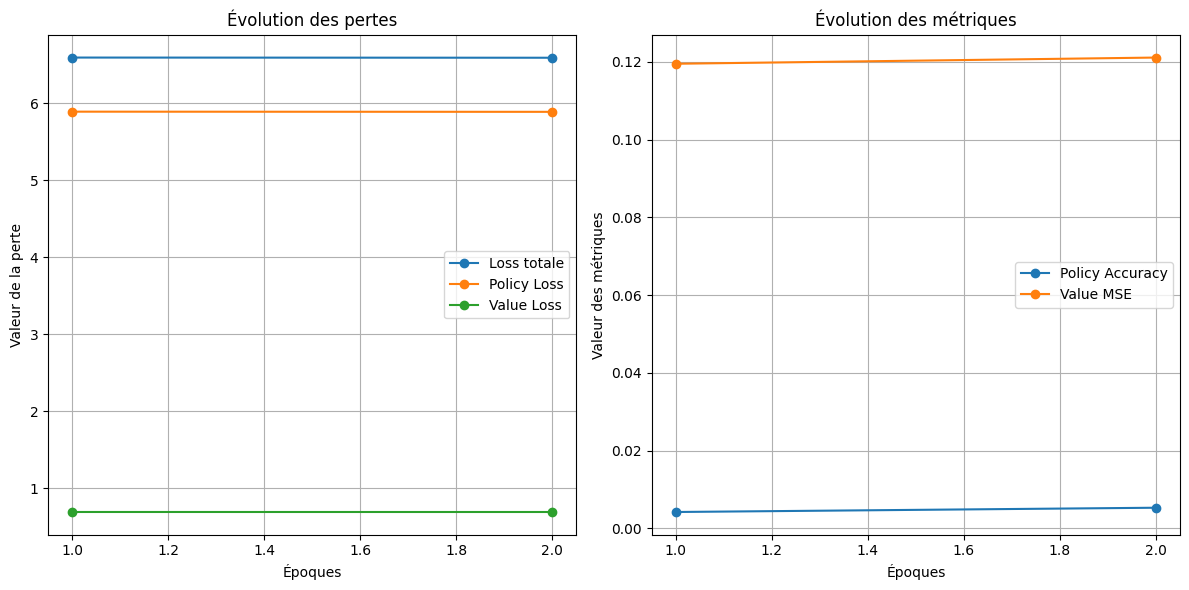

In [ ]:
GONetDemo_instance = GONetDemo()
GONetDemo_instance.workflow(
    epochs=2,
    batch=128,
    name="gonetdemo.h5",
    log_accuracy_dict=log_accuracy_dict,
)

# ResNet

« Un réseau neuronal résiduel ou réseau de neurones résiduel est une architecture de réseaux de neurones caractérisée par l'emploi de connexions résiduelles ou connexions saute-couches.

ResNet est un nom propre qui désigne le réseau neuronal résiduel qui a remporté la compétition ILSVRC en 2015.

Un réseau de neurones résiduel (ResNet) est un réseau de neurones artificiels (artificial neuronal network) qui s'appuie sur des constructions connues à partir de cellules pyramidales du cortex cérébral. Pour ce faire, les réseaux de neurones résiduels utilisent des connexions saute-couches, i.e. des raccourcis, pour sauter par-dessus certaines couches. » (cf. https://datafranca.org/wiki/R%C3%A9seau_neuronal_r%C3%A9siduel).

Le principe des réseaux résiduels consiste à ajouter l'entrée d'une couche à sa sortie. Grâce à cette simple modification, l'entraînement est plus rapide et permet la construction de réseaux plus profonds.
L'utilisation des réseaux résiduels pour le Go permet d'accélérer l'apprentissage, d'augmenter la précision et de permettre l'entraînement de réseaux plus profonds (cf. https://www.lamsade.dauphine.fr/~cazenave/papers/resnet.pdf).

L'implémentation du réseau de neurones résiduel implémenté s'appuie sur celle réalisée dans https://www.lamsade.dauphine.fr/~cazenave/papers/resnet.pdf.

L


In [1]:
class GONetResNet(GONet):

    def __init__(
        self,
        moves=361,
        N=10000,
        planes=31,
        num_blocks=5
    ):
        super().__init__(moves, N, planes)
        self.num_blocks = num_blocks

    def __init__(self, input_shape=(19, 19, 31), num_blocks=5, filters=32):
        self.input_layer = layers.Input(shape=input_shape)
        self.filters = filters
        self.num_blocks = num_blocks
        self.set_backbone()
        self.model = models.Model(inputs=self.input_layer, outputs=self.x)

    def residual_block(self, x):
        conv_5x5 = layers.Conv2D(self.filters, 5, padding="same")(x)
        conv_1x1 = layers.Conv2D(self.filters, 1, padding="same")(x)
        added = layers.Add()([conv_5x5, conv_1x1])
        return layers.Activation("relu")(added)

    def set_backbone(self):
        x = self.input_layer
        for _ in range(self.num_blocks):
            x = self.residual_block(x)
        self.x = x

NameError: name 'GONet' is not defined

# Première implémentation

ATTENTION : Soit utiliser l'implémentation de Deep learning and the game of go soit utiliser du zero padding entre les couches de convolution.

Sur la base de nos travaux de recherches bibliographiques, nous avons étudié deux implémentation différentes de réseaux de neurones pour jouer au jeu de Go. La première implémentation est inspirée du travail de [Silver et al. (2016)](https://www.nature.com/articles/nature16961) et utilise un réseau de neurones convolutionnel avec deux têtes : une pour la politique et une pour la valeur. La seconde implémentation est inspirée du travail de [Silver et al. (2017)](https://www.nature.com/articles/nature24270) et utilise un réseau de neurones profond avec plusieurs couches cachées.

Dans un premier temps, nous allons réaliser deux implémentations de réseau de neurone de convolution présentés dans [Deep learning and the game of go, pp. 164-167](https://www.manning.com/books/deep-learning-and-the-game-of-go). La première structure (cf. https://github.com/ejhg/dlgo/blob/master/betago/networks/small.py) est plus simple et plus rapide à entraîner, tandis que la seconde est plus complexe et nécessite plus de temps d'entraînement (cf. https://github.com/ejhg/dlgo/blob/master/betago/networks/large.py). Commençons par la première implémentation.

Dans le cadre de notre étude bibliographique certains auteurs ont fait état de l'utilité d'utiliser du zero padding entre les couches de convolution pour conserver les dimensions entre couche de convolution. L'usage du zero padding est une technique courante dans les réseaux de neurones convolutionnels, car elle permet de conserver la taille des cartes de caractéristiques (feature maps) après l'application de convolutions. Cela peut être particulièrement utile lorsque l'on souhaite maintenir la résolution spatiale des données d'entrée tout au long du réseau. En effet, le zero padding permet d'ajouter des zéros autour des bords de l'image d'entrée, ce qui évite la réduction de la taille des cartes de caractéristiques à chaque couche de convolution. Cela peut également aider à préserver les informations aux bords de l'image et à éviter la perte d'informations importantes lors du traitement des données.
L'usagedu zero padding nécessite de supprimer la valeur `padding='same'` dans les couches de convolution. En effet, cette valeur permet de conserver la taille des cartes de caractéristiques après l'application de convolutions, ce qui n'est pas nécessaire si l'on utilise du zero padding. En revanche, il est important de s'assurer que les dimensions des cartes de caractéristiques sont compatibles entre les différentes couches du réseau. Si les dimensions ne correspondent pas, cela peut entraîner des erreurs lors de l'entraînement du modèle.


In [ ]:
class GONetCNNZeroPadding(GONet):

    def __init__(
        self,
        moves=361,
        N=10000,
        planes=31,
    ):
        super().__init__(moves, N, planes)

    def set_backbone(self):
        """
        Définit l'architecture du tronc du réseau de neurones.

        Args: None

        Returns:
            None: Affecte self.x (sortie du tronc)
        """
        filters = 32
        x = layers.Conv2D(filters, 1, activation="relu", padding="same")(
            self.input_layer
        )
        for _ in range(5):
            x = layers.Conv2D(filters, 3, activation="relu")(x)
            x = layers.ZeroPadding2D(padding=(1, 1))(x)
        self.x = x

In [ ]:
GONetCNNZeroPadding_instance = GONetCNNZeroPadding()
GONetCNNZeroPadding_instance.set_backbone()

In [ ]:
GONetCNNZeroPadding_instance.workflow(
    epochs=10,
    batch=128,
    name="gonetzeropadding.h5",
    log_accuracy_dict=log_accuracy_dict,
)

## Mobile Network

In [ ]:
class GONetCNNMobileNetwork(GONet):

    def __init__(
        self,
        moves=361,
        N=10000,
        planes=31,
        filters=512,
        trunk=32,
        blocks=5,
    ):
        super().__init__(moves, N, planes)
        self.filters = filters
        self.trunk = trunk
        self.blocks = blocks

    @staticmethod
    def bottleneck_block(x, expand=512, squeeze=128):
        m = layers.Conv2D(
            expand,
            (1, 1),
            kernel_regularizer=regularizers.l2(0.0001),
            use_bias=False,
        )(x)
        m = layers.BatchNormalization()(m)
        m = layers.Activation("relu")(m)
        m = layers.DepthwiseConv2D(
            (3, 3),
            padding="same",
            kernel_regularizer=regularizers.l2(0.0001),
            use_bias=False,
        )(m)
        m = layers.BatchNormalization()(m)
        m = layers.Activation("relu")(m)
        m = layers.Conv2D(
            squeeze,
            (1, 1),
            kernel_regularizer=regularizers.l2(0.0001),
            use_bias=False,
        )(m)
        m = layers.BatchNormalization()(m)
        return layers.Add()([m, x])

    def set_backbone(self):
        """
        Définit l'architecture du tronc du réseau de neurones.

        Args: None

        Returns:
            None: Affecte self.x (sortie du tronc)
        """
        x = layers.Conv2D(
            self.trunk,
            1,
            padding="same",
            kernel_regularizer=regularizers.l2(0.0001),
        )(self.input_layer)
        print(f"{x.shape=}")
        x = layers.BatchNormalization()(x)
        print(f"{x.shape=}")
        x = layers.ReLU()(x)
        print(f"{x.shape=}")
        for i in range(self.blocks):
            x = self.bottleneck_block(
                x, expand=self.filters, squeeze=self.trunk
            )
            print(f"{x.shape=}")
        print(f"{x.shape=}")
        self.x = x

In [ ]:
GONetCNNMobileNetwork_instance = GONetCNNMobileNetwork()
GONetCNNMobileNetwork_instance.set_backbone()

r.shape = (10000, 19, 19, 31)
nbExamples = 10000


x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])


In [ ]:
GONetCNNMobileNetwork_instance.set_model()
# GONetCNNMobileNetwork_instance.save_model(
#     name="gonetcnnmobilenetwork.h5"
# )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 19, 19, 31)]         0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 19, 19, 32)           1024      ['board[0][0]']               
                                                                                                  
 batch_normalization_16 (Ba  (None, 19, 19, 32)           128       ['conv2d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_1 (ReLU)              (None, 19, 19, 32)           0         ['batch_normalization_16[0

In [ ]:
GONetCNNMobileNetwork_instance.workflow(
    epochs=10,
    batch=128,
    name="gonetcnnmobilenetwork.h5",
    log_accuracy_dict={},
)

x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
x.shape=TensorShape([None, 19, 19, 32])
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 19, 19, 31)]         0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 19, 19, 32)           1024      ['board[0][0]']               
                                                                                                  
 batch_normalization_32 (Ba  

r.shape = (10000, 19, 19, 31)
nbExamples = 10000
2025-04-12 15:20:17.620830: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 447640000 exceeds 10% of free system memory.
2025-04-12 15:20:18.126428: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14440000 exceeds 10% of free system memory.
2025-04-12 15:20:18.225182: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 447640000 exceeds 10% of free system memory.
2025-04-12 15:20:18.380791: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14440000 exceeds 10% of free system memory.
2025-04-12 15:20:22.871381: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-04-12 15:20:34.661112: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 90.25MiB (rounded to 94633984)requested by op model_1/batch_normalization_46/FusedBatchNormV3
If the

ResourceExhaustedError: Graph execution error:

Detected at node model_1/batch_normalization_46/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_1529/2354059667.py", line 1, in <module>

  File "/tmp/ipykernel_1529/2721073593.py", line 355, in workflow

  File "/tmp/ipykernel_1529/2721073593.py", line 236, in train_model

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/aurelien/workspace/Deep_learning/deep_learning_go/src/venv/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[128,512,19,19] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/batch_normalization_46/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_7107]

In [ ]:
filters = 512
trunk = 128
def bottleneck_block(x, expand=filters, squeeze=trunk):
  m = layers.Conv2D(
    expand, (1,1),
    kernel_regularizer=regularizers.l2(0.0001),
    use_bias = False
  )(x)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = layers.DepthwiseConv2D((3,3), padding='same',
  kernel_regularizer=regularizers.l2(0.0001),
  use_bias = False)(m)
  m = layers.BatchNormalization()(m)
  m = layers.Activation('relu')(m)
  m = layers.Conv2D(squeeze, (1,1),
  kernel_regularizer=regularizers.l2(0.0001),
  use_bias = False)(m)
  m = layers.BatchNormalization()(m)
  return layers.Add()([m, x])
def getModel ():
  input = keras.Input(shape=(19, 19, 21), name='board')
  x = layers.Conv2D(trunk, 1, padding='same',
  kernel_regularizer=regularizers.l2(0.0001))(input)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  for i in range (blocks):
    x = bottleneck_block (x, filters, trunk)
  policy_head = layers.Conv2D(1, 1, activation='relu', padding='same',
  use_bias = False,
  kernel_regularizer=regularizers.l2(0.0001))(x)
  policy_head = layers.Flatten()(policy_head)
  policy_head = layers.Activation('softmax', name='policy')(policy_head)
  value_head = layers.GlobalAveragePooling2D()(x)
  value_head = layers.Dense(50, activation='relu',
  kernel_regularizer=regularizers.l2(0.0001))(value_head)
  value_head = layers.Dense(1, activation='sigmoid', name='value',
  kernel_regularizer=regularizers.l2(0.0001))(value_head)
  model = keras.Model(inputs=input, outputs=[policy_head, value_head])
  return model

In [ ]:
class GONetCNNSmall(GONet):

    def __init__(
        self,
        moves=361,
        N=10000,
        planes=31,
    ):
        super().__init__(moves, N, planes)

    def set_backbone(self):
        """
        Définit l'architecture du tronc du réseau de neurones.

        Args: None

        Returns:
            None: Affecte self.x (sortie du tronc)
        """
        x = layers.ZeroPadding2D(
            padding=(0, 0),  # aucun padding pour conserver la dimension 19x19
            data_format="channels_last"
        )(self.input_layer)

        x = layers.Conv2D(
            filters=32,
            kernel_size=(7, 7),
            padding="same",  # conserve la taille 19x19
            activation="relu",
            data_format="channels_last"
        )(x)
        print(f"{x.shape=}")

        x = layers.ZeroPadding2D(
            padding=(0, 0),  # aucun padding pour conserver la dimension 19x19
            data_format="channels_last",
        )(x)
        print(f"{x.shape=}")

        x = layers.Conv2D(
            filters=32,
            kernel_size=(48, 48),
            padding="same",  # conserve la taille 19x19
            activation="relu",
            data_format="channels_last",
        )(x)
        print(f"{x.shape=}")

    # return [
    #     ZeroPadding2D(
    #         (3, 3), input_shape=input_shape, data_format="channels_first"
    #     ),
    #     Conv2D(48, (7, 7), padding="valid", data_format="channels_first"),
    #     Activation("relu"),
    #     ZeroPadding2D((2, 2), data_format="channels_first"),
    #     Conv2D(32, (5, 5), data_format="channels_first"),
    #     Activation("relu"),
    #     ZeroPadding2D((2, 2), data_format="channels_first"),
    #     Conv2D(32, (5, 5), data_format="channels_first"),
    #     Activation("relu"),
    #     ZeroPadding2D((2, 2), data_format="channels_first"),
    #     Conv2D(32, (5, 5), data_format="channels_first"),
    #     Activation("relu"),
    #     Flatten(),
    #     Dense(512),
    #     Activation("relu"),
    # ]

In [ ]:
GONetCNNSmall_instance = GONetCNNSmall()
GONetCNNSmall_instance.set_backbone()
# GONetCNNSmall_instance.workflow(
#     epochs=2,
#     batch=128,
#     name="gonetdemo.h5",
#     log_accuracy_dict=log_accuracy_dict,
# )

# Réseaux de neurones résiduels

La couche standard utilisée dans les programmes de Go computationnel tels que AlphaGo \cite{AlphaGo} et DarkForest \cite{DarkForest} est généralement constituée d’une couche convolutionnelle suivie d’une activation ReLU, comme illustré en Figure~1.

La couche résiduelle, souvent utilisée pour des tâches de classification d’images, consiste à additionner l’entrée de la couche avec sa sortie. Elle est composée de deux couches convolutionnelles consécutives, entre lesquelles des activations ReLU sont appliquées après la première convolution et après l’opération d’addition. Cette structure est représentée en Figure~2. Nous envisageons d’exploiter ce type de couches résiduelles dans le cadre de nos réseaux dédiés au jeu de Go.

La couche d’entrée de nos réseaux pour le Go adopte elle aussi une structure résiduelle. Elle repose sur une combinaison parallèle de deux couches convolutionnelles : l’une de taille $5 \times 5$ et l’autre de taille $1 \times 1$. Leurs sorties respectives sont additionnées, puis une activation ReLU est appliquée. Cette architecture est illustrée en Figure~3.

La couche de sortie du réseau est constituée d’une couche convolutionnelle de taille $3 \times 3$, produisant un unique plan de sortie, suivie d’une fonction d’activation SoftMax. L’ensemble des couches cachées du réseau utilise des filtres de taille $3 \times 3$ avec 256 plans de caractéristiques.

Dans le cadre de cet article, nous définissons la profondeur d’un réseau comme étant le nombre total de couches convolutionnelles. Ainsi, un réseau à 28 couches comprend 28 couches convolutionnelles, correspondant à 14 blocs résiduels tels que décrits en Figure~2.

In [ ]:
class GONetRes_residual(GONet):

    def __init__(
        self,
        moves=361,
        N=10000,
        planes=31,
    ):
        super().__init__(moves, N, planes)

    def residual_block(self, x, filters, name_prefix):
        skip = x
        x = layers.Conv2D(
            filters,
            3,
            padding="same",
            activation="relu",
            name=f"{name_prefix}_conv1",
        )(x)
        x = layers.Conv2D(
            filters, 3, padding="same", name=f"{name_prefix}_conv2"
        )(x)
        x = layers.Add(name=f"{name_prefix}_add")([x, skip])
        x = layers.Activation("relu", name=f"{name_prefix}_relu")(x)
        return x

    def go_residual_input(self, x, filters):
        conv_5x5 = layers.Conv2D(
            filters, 5, padding="same", name="input_conv5x5"
        )(x)
        conv_1x1 = layers.Conv2D(
            filters, 1, padding="same", name="input_conv1x1"
        )(x)
        x = layers.Add(name="input_add")([conv_5x5, conv_1x1])
        x = layers.Activation("relu", name="input_relu")(x)
        return x

    def set_backbone(self, filters=256, n_blocks=14):
        x = self.go_residual_input(self.input_layer, filters)
        for i in range(n_blocks):
            x = self.residual_block(x, filters, name_prefix=f"res{i+1}")
        self.x = x

In [ ]:
GONetRes_residual_instance = GONetRes_residual()
GONetRes_residual_instance.set_backbone()
GONetRes_residual_instance.train_model(epochs=2)
GONetRes_residual_instance.plot_training_history()
GONetRes_residual_instance.log_accuracy(log_accuracy_dict)

Création de la classe `GONetRes_cnn`

In [ ]:
class GONetRes_cnn(GONet):
    def __init__(
        self, batch=128, epochs=20, filters=32, moves=361, N=10000, planes=31
    ):
        super().__init__(batch, epochs, filters, moves, N, planes)

    def create_policy_value_heads(self, x, input_layer):
        """
        Fonction de création des en-têtes de politique et de valeur.
        """
        policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False)(x)
        policy_head = layers.Flatten()(policy_head)
        policy_head = layers.Activation('softmax', name='policy')(policy_head)

        value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False)(x)
        value_head = layers.Flatten()(value_head)
        value_head = layers.Dense(50, activation='relu')(value_head)
        value_head = layers.Dense(1, activation='sigmoid', name='value')(value_head)

        model = models.Model(inputs=input_layer, outputs=[policy_head, value_head])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                      loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
                      metrics={'policy': 'categorical_accuracy', 'value': 'mse'})
        return model

    def set_model(self, filters=32, planes=31):
        input_layer = layers.Input(shape=(19, 19, planes), name='board')
        x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input_layer)
        for _ in range(5):
            x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        self.model = self.create_policy_value_heads(x, input_layer)

In [ ]:
GONetRes_cnn_instance = GONetRes_cnn()
GONetRes_cnn_instance.set_model()
GONetRes_cnn_instance.train_model(20)
GONetRes_cnn_instance.plot_training_history()
GONetRes_cnn_instance.log_accuracy(log_accuracy_dict)

## Création de la classe `GONetRes_resnet`

In [ ]:
class GONetRes_resnet(GONet):
    def __init__(
        self, batch=128, epochs=20, filters=32, moves=361, N=10000, planes=31
    ):
        super().__init__(batch, epochs, filters, moves, N, planes)

    def create_policy_value_heads(self, x, input_layer):
        """
        Fonction de création des en-têtes de politique et de valeur.
        """
        policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False)(x)
        policy_head = layers.Flatten()(policy_head)
        policy_head = layers.Activation('softmax', name='policy')(policy_head)

        value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False)(x)
        value_head = layers.Flatten()(value_head)
        value_head = layers.Dense(50, activation='relu')(value_head)
        value_head = layers.Dense(1, activation='sigmoid', name='value')(value_head)

        model = models.Model(inputs=input_layer, outputs=[policy_head, value_head])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                      loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
                      metrics={'policy': 'categorical_accuracy', 'value': 'mse'})
        return model

    def residual_block(self, x, filters):
        shortcut = x
        x = layers.Conv2D(filters, (3,3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3,3), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x

    def set_model(self, filters=64, planes=31):
        input_layer = layers.Input(shape=(19, 19, planes), name='board')
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(input_layer)
        for _ in range(5):
            x = self.residual_block(x, filters)
        self.model = self.create_policy_value_heads(x, input_layer)

In [ ]:
GONetRes_resnet_instance = GONetRes_resnet()
GONetRes_resnet_instance.set_model()
GONetRes_resnet_instance.train_model(20)
GONetRes_resnet_instance.plot_training_history()
GONetRes_resnet_instance.log_accuracy(log_accuracy_dict)

In [ ]:
save_best_model(log_accuracy_dict)

**Compare Resnets, Mobilenets and Convnexts, Shufflenet by training on the game of go**

# *Shufflenet*

*ShuffleNet* est une architecture de réseau neuronal conçue pour être rapide et efficace. Elle repose sur le concept de permutation des canaux du tenseur d’entrée, ce qui améliore l’efficacité en termes de calcul et d’utilisation de la mémoire.

Le réseau se compose de deux principales parties :

1.  Couche de convolution : Cette couche a pour rôle d’extraire les caractéristiques du tenseur d’entrée.

2.  Couche de permutation (*shuffling*) : Cette couche permutent les canaux du tenseur d’entrée. Elle est conçue pour être légère et efficace, ce qui contribue fortement à la performance globale et à l’efficacité du réseau

*Shufflenet* est un mobilenet avec moins de paramètres puisqu'il y a des plans séparés.

In [ ]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    DepthwiseConv2D,
    Dense,
    Concatenate,
    Add,
    ReLU,
    BatchNormalization,
    AvgPool2D,
    MaxPool2D,
    GlobalAveragePooling2D,
    Reshape,
    Permute,
    Lambda,
    Flatten,
    Activation,
)


class GONetRes_shufflenet(GONet):

    def __init__(
        self,
        batch=128,
        epochs=20,
        filters=32,
        moves=361,
        N=10000,
        planes=31,
        trunk=32,  # trunk (hyperparamètre) : nombre de filtres dans le tronc (32, 64, etc.). Dans le modèle de go il est de l'ordre de 32.
        blocks=5,  # blocks : nombre de blocs résiduels
    ):
        super().__init__(batch, epochs, filters, moves, N, planes)
        self.trunk = trunk
        self.blocks = blocks

    def create_policy_value_heads(self, x, input_layer):
        input = keras.Input(shape=(19, 19, self.planes), name="board")
        x = Conv2D(
            self.trunk,
            1,
            padding="same",
            kernel_regularizer=regularizers.l2(0.0001),
        )(input)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        for i in range(self.blocks):
            x = self.bottleneck_block(x, self.filters, self.trunk)
        policy_head = Conv2D(
            1,
            1,
            activation="relu",
            padding="same",
            use_bias=False,
            kernel_regularizer=regularizers.l2(0.0001),
        )(x)
        policy_head = Flatten()(policy_head)
        policy_head = Activation("softmax", name="policy")(policy_head)
        value_head = GlobalAveragePooling2D()(x)
        value_head = Dense(
            50, activation="relu", kernel_regularizer=regularizers.l2(0.0001)
        )(value_head)
        value_head = Dense(
            1,
            activation="sigmoid",
            name="value",
            kernel_regularizer=regularizers.l2(0.0001),
        )(value_head)
        model = keras.Model(inputs=input, outputs=[policy_head, value_head])
        return model

    def bottleneck_block(self, tensor, expand=96, squeeze=16):
        x = self.gconv(tensor, channels=expand, groups=4)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = self.channel_shuffle(x, groups=4)
        # Depthwise (comme dans les mobilenets)
        x = DepthwiseConv2D(kernel_size=3, padding="same")(x)
        x = BatchNormalization()(x)
        x = self.gconv(x, channels=squeeze, groups=4)
        x = BatchNormalization()(x)
        x = Add()([tensor, x])
        # Les connexions résiduelles ajoutent de la souplesse et permettre de
        # rendre les réseaux plus entraînables
        output = ReLU()(x)
        return output

    def gconv(tensor, channels, groups):
        """
        gconv permet de faire un groupe de convolution sur l'entrée du tenseur

        Args:
            tensor (_type_): _description_
            channels (_type_): _description_
            groups (_type_): _description_

        Returns:
            _type_: _description_
        """
        input_ch = tensor.get_shape().as_list()[-1]
        group_ch = input_ch // groups
        output_ch = channels // groups
        groups_list = []
        for i in range(groups):
            group_tensor = tensor[:, :, :, i * group_ch : (i + 1) * group_ch]
            group_tensor = Conv2D(output_ch, 1)(group_tensor)
            groups_list.append(group_tensor)
        output = Concatenate()(groups_list)
        return output

    def channel_shuffle(self, x, groups):
        _, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups
        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

# Glossaire

#### Réseau de neurones *feed forward* :

« Un réseau de neurones à propagation avant, en anglais *feed forward neural network*, est un réseau de neurones artificiels acyclique, se distinguant ainsi des réseaux de neurones récurrents. Le plus connu est le perceptron multicouche qui est une extension du premier réseau de neurones artificiel. Le perceptron a été inventé en 1957 par Frank Rosenblatt.

Le réseau de neurones à propagation avant a été le premier et le plus simple type de réseau neuronal artificiel conçu. Typiquement, il ne comportait qu'une seule couche cachée et s'appelait perceptron. Dans ce réseau, l'information ne se déplace que dans une seule direction, vers l'avant, à partir des nœuds d'entrée, en passant par les couches cachées (le cas échéant) et vers les nœuds de sortie. Il n'y a pas de cycles ou de boucles dans ce réseau. C'est pourquoi on le désigne parfois par réseau de neurones sans boucle.

Quand le réseau de neurones à propagation avant comporte plusieurs couches cachées, on parle habituellement d'un perceptron multicouche. » (cf. [Réseau de neurones *feed forward*](https://datafranca.org/wiki/R%C3%A9seau_de_neurones_%C3%A0_propagation_avant))



![Réseau de neurones *feed forward*](https://upload.wikimedia.org/wikipedia/commons/8/82/FeedForwardNN.png)

